Cell 1: Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Cell 2: Load Data

In [2]:
# Load the datasets
train_data = pd.read_csv('D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/train_70_15_15.csv')
val_data = pd.read_csv('D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/val_70_15_15.csv')
test_data = pd.read_csv('D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/test_70_15_15.csv')

# Display basic information
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display first few rows of training data
train_data.head()

Training data shape: (2720, 8)
Validation data shape: (582, 8)
Test data shape: (584, 8)


,Date,Price,Open,High,Low,Vol.,Change %,CPIAUCSL
0,1/4/2010,"1,118.30","1,099.00","1,124.60","1,093.80",155.48K,2.02%,217.488
1,1/5/2010,"1,118.70","1,122.00","1,129.60","1,115.50",156.41K,0.04%,217.488
2,1/6/2010,"1,136.50","1,118.50","1,141.00","1,116.80",176.90K,1.59%,217.488
3,1/7/2010,"1,133.70","1,139.00","1,139.50","1,128.70",121.15K,-0.25%,217.488
4,1/8/2010,"1,138.90","1,131.50","1,140.00","1,119.50",212.62K,0.46%,217.488


Cell 3: Check Missing Values

In [3]:
# Check for missing values
print("Missing values in training data:\n", train_data.isnull().sum())
print("\nMissing values in validation data:\n", val_data.isnull().sum())
print("\nMissing values in test data:\n", test_data.isnull().sum())

Missing values in training data:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    0
CPIAUCSL    0
dtype: int64

Missing values in validation data:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64

Missing values in test data:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        2
Change %    0
CPIAUCSL    0
dtype: int64


Cell 4: Data Preprocessing

In [4]:
# Cell 4: Data Preprocessing (Updated)

# Feature selection
selected_features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']

# Check if all selected features exist in the dataframe
for feature in selected_features:
    if feature not in train_data.columns:
        print(f"Warning: '{feature}' not found in the dataset. Available columns are: {train_data.columns.tolist()}")

# Function to preprocess data
def preprocess_data(data):
    # Make a copy to avoid modifying the original data
    df = data.copy()
    
    # Columns that might have commas and need conversion to float
    cols_to_convert = ['Price', 'Open', 'High', 'Low'] # Potentially 'Vol.' before 'K'/'M' replacement
    
    for col in cols_to_convert:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)

    # Convert 'Change %' from string to float if needed
    if df['Change %'].dtype == 'object':
        df['Change %'] = df['Change %'].astype(str).str.replace('%', '', regex=False).astype(float)
    
    # Convert 'Vol.' from string to float if needed
    if df['Vol.'].dtype == 'object':
        # First, remove commas if they exist (e.g., "1,234.5K")
        df['Vol.'] = df['Vol.'].astype(str).str.replace(',', '', regex=False)
        # Then, handle 'K' and 'M'
        df['Vol.'] = df['Vol.'].str.replace('K', 'e3', regex=False).str.replace('M', 'e6', regex=False).astype(float)
    
    # Handle missing values if any, AFTER all type conversions
    # For 'Vol.', missing values might arise if original string was unparseable even after K/M conversion, though ffill handles most cases.
    df = df.fillna(method='ffill') 
    df = df.fillna(method='bfill') # Add bfill for any remaining NaNs at the beginning
    
    return df

# Preprocess datasets
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

# Extract selected features
X_train = train_data[selected_features].values
X_val = val_data[selected_features].values
X_test = test_data[selected_features].values

# Target variable (Gold Price)
y_train = train_data['Price'].values
y_val = val_data['Price'].values
y_test = test_data['Price'].values

# Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Normalize target variable separately to make inverse transform easier later
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Check for any remaining NaNs after preprocessing, before scaling
print("\\nChecking for NaNs in selected features after preprocessing:")
print("Train data NaNs:\n", train_data[selected_features].isnull().sum())
print("Val data NaNs:\n", val_data[selected_features].isnull().sum())
print("Test data NaNs:\n", test_data[selected_features].isnull().sum())

print("\\nData types of selected features after preprocessing (Train):")
print(train_data[selected_features].dtypes)

print("\\nSample of X_train before scaling (first 5 rows):")
print(X_train[:5])

\nChecking for NaNs in selected features after preprocessing:
Train data NaNs:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64
Val data NaNs:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64
Test data NaNs:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64
\nData types of selected features after preprocessing (Train):
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
CPIAUCSL    float64
dtype: object
\nSample of X_train before scaling (first 5 rows):
[[ 1.11830e+03  1.09900e+03  1.12460e+03  1.09380e+03  1.55480e+05
   2.02000e+00  2.17488e+02]
 [ 1.11870e+03  1.12200e+03  1.12960e+03  1.11550e+03  1.56410e+05
   4.00000e-02  2.17488e+02]
 [ 1.13650e+03  1.11850e+03  1.14100e+03  1.11680e+03  1.76900e+05
   1.59000e+00  2.17488e+02

C:\Users\Admin\AppData\Local\Temp\ipykernel_33136\1026396546.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_33136\1026396546.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill') # Add bfill for any remaining NaNs at the beginning
C:\Users\Admin\AppData\Local\Temp\ipykernel_33136\1026396546.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_33136\1026396546.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill') 

Cell 5: Create Time Series Sequences

In [5]:
# Create sequences for time series data
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Define time steps
TIME_STEPS = 90

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"Training sequences shape: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}, {y_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}, {y_test_seq.shape}")

Training sequences shape: (2630, 90, 7), (2630, 1)
Validation sequences shape: (492, 90, 7), (492, 1)
Test sequences shape: (494, 90, 7), (494, 1)


Cell 6: Custom Dataset for PyTorch

In [6]:
# Custom Dataset class for PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
val_dataset = TimeSeriesDataset(X_val_seq, y_val_seq)
test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Cell 7: Build GRU Model with PyTorch

In [7]:
# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # GRU layers
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            layer_dim, 
            batch_first=True, 
            dropout=dropout_prob if layer_dim > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout_prob)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Extract the output of the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Linear layer for prediction
        out = self.fc(out)
        
        return out

# Set model parameters
input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64  # Hidden layer dimension
layer_dim = 2  # Number of GRU layers
output_dim = 1  # Output dimension (predicting gold price)
dropout_prob = 0.2  # Dropout probability

# Create the model
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob)

# Model summary
def model_summary(model):
    print(f"Model: {model.__class__.__name__}")
    print("\nModel Architecture:")
    print(model)
    
    # Count parameters
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {params}")

model_summary(model)

Model: GRUModel

Model Architecture:
GRUModel(
  (gru): GRU(7, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Total Trainable Parameters: 39041


Cell 8: Training Function

In [8]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            self.status = f"No improvement in {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, patience=15):
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)
    
    # Track loss history
    train_losses = []
    val_losses = []
    
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model.to(device)
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            
            # Calculate loss
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Update running loss
            train_loss += loss.item() * X_batch.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                y_pred = model(X_batch)
                
                # Calculate loss
                loss = criterion(y_pred, y_batch)
                
                # Update running loss
                val_loss += loss.item() * X_batch.size(0)
        
        # Calculate average validation loss
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # Check early stopping
        if early_stopping(val_loss, model):
            print(early_stopping.status)
            break
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion, 
    num_epochs=100, 
    patience=15
)

Using device: cpu
Epoch 1/100 | Train Loss: 0.016986 | Val Loss: 0.000759
Epoch 2/100 | Train Loss: 0.002482 | Val Loss: 0.000767
Epoch 3/100 | Train Loss: 0.002275 | Val Loss: 0.000733
Epoch 4/100 | Train Loss: 0.001944 | Val Loss: 0.004283
Epoch 5/100 | Train Loss: 0.001912 | Val Loss: 0.001327
Epoch 6/100 | Train Loss: 0.001842 | Val Loss: 0.000580
Epoch 7/100 | Train Loss: 0.001689 | Val Loss: 0.000905
Epoch 8/100 | Train Loss: 0.001472 | Val Loss: 0.000550
Epoch 9/100 | Train Loss: 0.001480 | Val Loss: 0.000659
Epoch 10/100 | Train Loss: 0.001448 | Val Loss: 0.000865
Epoch 11/100 | Train Loss: 0.001433 | Val Loss: 0.000447
Epoch 12/100 | Train Loss: 0.001305 | Val Loss: 0.000656
Epoch 13/100 | Train Loss: 0.001317 | Val Loss: 0.000507
Epoch 14/100 | Train Loss: 0.001233 | Val Loss: 0.000522
Epoch 15/100 | Train Loss: 0.001159 | Val Loss: 0.000421
Epoch 16/100 | Train Loss: 0.001112 | Val Loss: 0.001859
Epoch 17/100 | Train Loss: 0.001270 | Val Loss: 0.000951
Epoch 18/100 | Train L

Cell 9: Visualize Training History

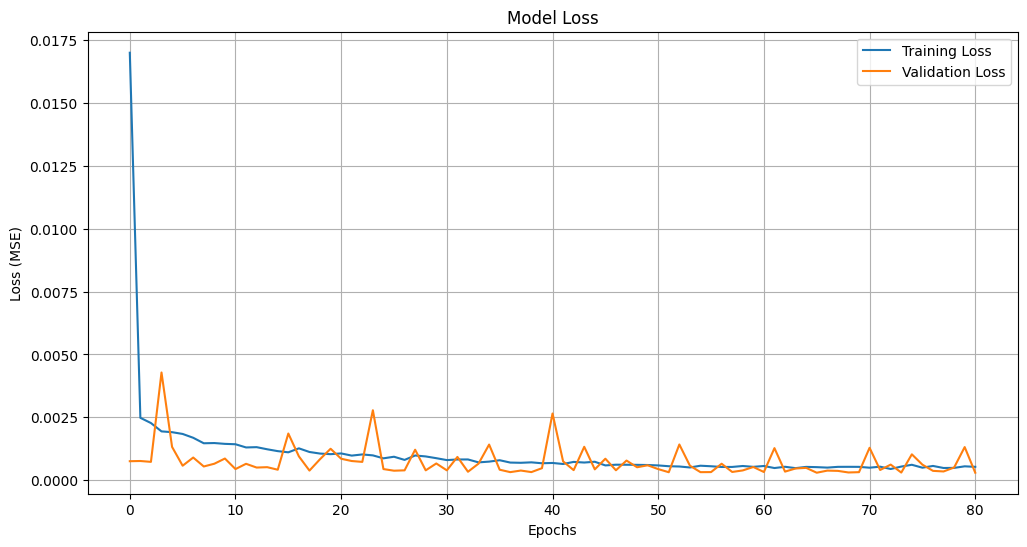

In [9]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)


Cell 10: Model Evaluation

In [10]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n, p):
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Root Mean Square Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # R² Score
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R²
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R²': r2,
        'Adjusted R²': adjusted_r2
    }

# Generate predictions
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

# Concatenate batches
test_predictions_scaled = np.concatenate(predictions)
y_test_actual_scaled = np.concatenate(actuals)

# Inverse transform to get actual gold price values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_actual_scaled)

# Calculate evaluation metrics
n = len(y_test_actual)  # Number of samples
p = input_dim  # Number of features
metrics = calculate_metrics(y_test_actual, test_predictions, n, p)

# Display metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 51.849098205566406
MAPE: 1.997046947479248
RMSE: 77.88371276855469
R²: 0.9485065340995789
Adjusted R²: 0.9477648586647991


Cell 11: Visualize Predictions

Text(0.15, 0.15, 'MAE: 51.8491\nMAPE: 1.9970\nRMSE: 77.8837\nR²: 0.9485\nAdjusted R²: 0.9478')

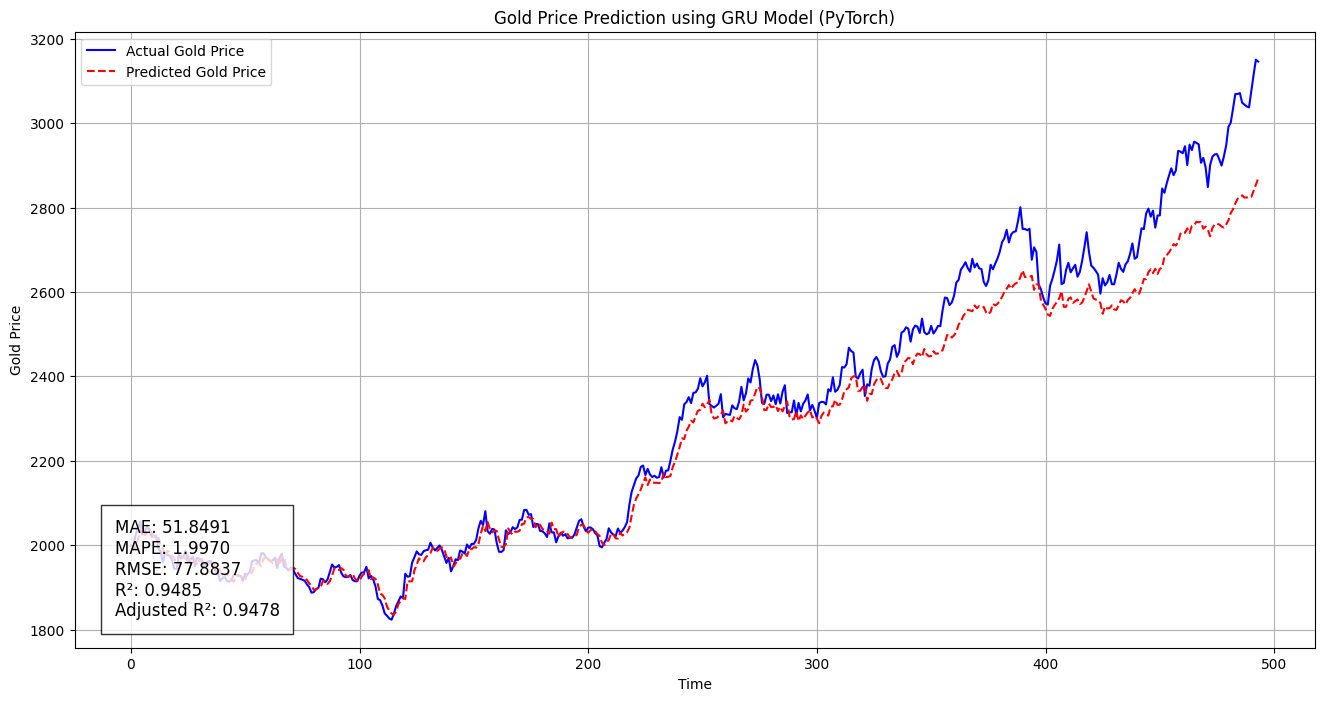

In [11]:
# Visualize actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual, label='Actual Gold Price', color='blue')
plt.plot(test_predictions, label='Predicted Gold Price', color='red', linestyle='--')
plt.title('Gold Price Prediction using GRU Model (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)

# Add metrics to the plot
metrics_text = '\n'.join([f"{key}: {value:.4f}" for key, value in metrics.items()])
plt.figtext(0.15, 0.15, metrics_text, fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})


Cell 122: Future Prediction and Combined Plot

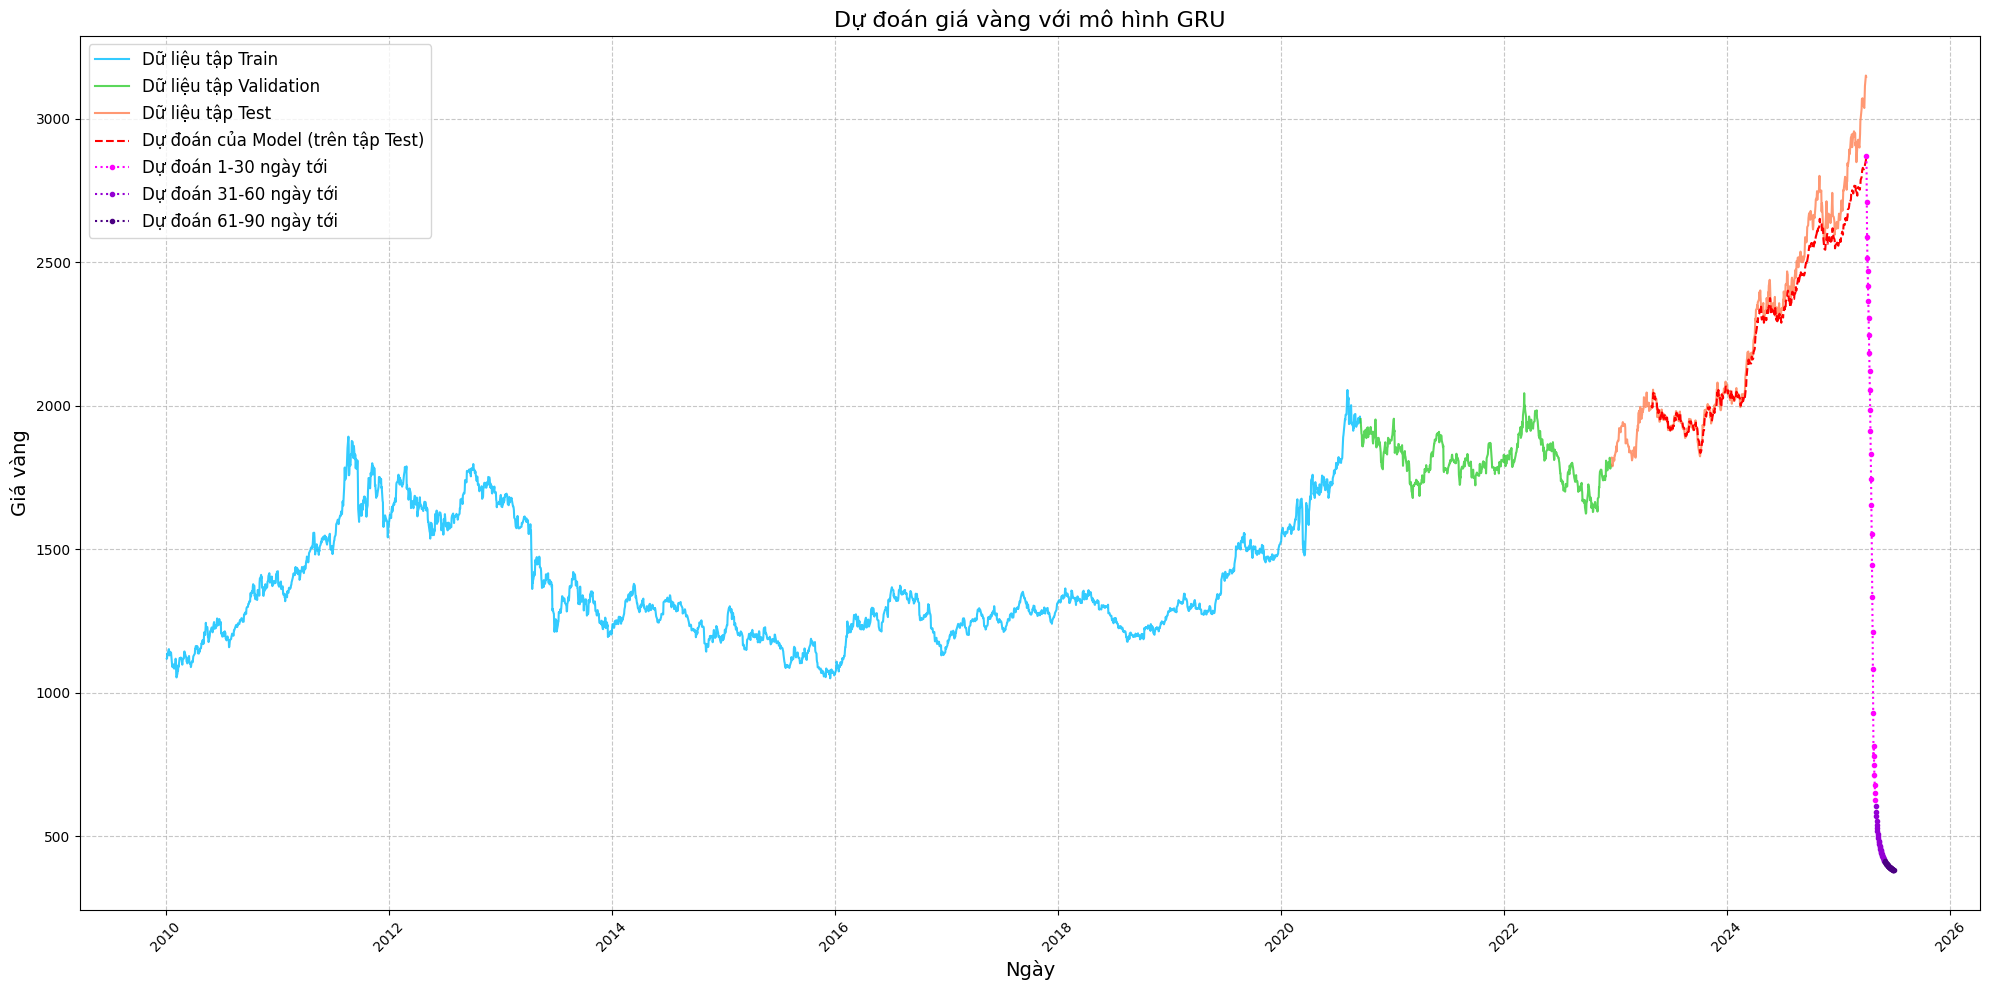

Future predictions for the next 90 days (first 5):
2025-04-02: 2870.78
2025-04-03: 2708.00
2025-04-04: 2587.11
2025-04-05: 2515.92
2025-04-06: 2467.60


In [15]:
# Ensure 'Date' column is in datetime format if not already
if not pd.api.types.is_datetime64_any_dtype(train_data['Date']):
    train_data['Date'] = pd.to_datetime(train_data['Date'])
if not pd.api.types.is_datetime64_any_dtype(val_data['Date']):
    val_data['Date'] = pd.to_datetime(val_data['Date'])
if not pd.api.types.is_datetime64_any_dtype(test_data['Date']):
    test_data['Date'] = pd.to_datetime(test_data['Date'])

# Number of future days to predict
N_FUTURE_DAYS = 90
# TIME_STEPS, device, model, scaler_X, scaler_y should be available from previous cells
# X_test_scaled, y_test_actual, test_predictions also should be available

# Get the last sequence of features from the test set (scaled)
# This sequence will be used to start the future prediction process
# X_test_scaled has all features, shape (num_test_samples, n_features)
last_actual_sequence_scaled = X_test_scaled[-TIME_STEPS:] # Shape (TIME_STEPS, n_features)

# Store future predictions (scaled)
future_predictions_scaled_list = []

# Set model to evaluation mode
model.eval()
# current_sequence_np will be updated in each iteration
current_sequence_np = last_actual_sequence_scaled.copy() 

# Define feature indices for clarity (ensure selected_features is available or redefine)
# selected_features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL'] # Should match Cell 4
price_idx = selected_features.index('Price')
open_idx = selected_features.index('Open')
high_idx = selected_features.index('High')
low_idx = selected_features.index('Low')
vol_idx = selected_features.index('Vol.')
change_pct_idx = selected_features.index('Change %')
cpi_idx = selected_features.index('CPIAUCSL')
n_features = len(selected_features)

for _ in range(N_FUTURE_DAYS):
    with torch.no_grad():
        # Prepare input tensor for this step, shape (1, TIME_STEPS, n_features)
        input_tensor = torch.tensor(current_sequence_np, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Predict the next scaled price (output shape is (1, 1))
        predicted_next_price_scaled_tensor = model(input_tensor)
        predicted_next_price_scaled = predicted_next_price_scaled_tensor.cpu().item()
        
    future_predictions_scaled_list.append(predicted_next_price_scaled)
    
    # Create the feature vector for the day we just predicted
    new_day_features_scaled = np.zeros(n_features)
    
    new_day_features_scaled[price_idx] = predicted_next_price_scaled
    # Assumptions for other features for the predicted day:
    new_day_features_scaled[open_idx] = predicted_next_price_scaled 
    new_day_features_scaled[high_idx] = predicted_next_price_scaled 
    new_day_features_scaled[low_idx] = predicted_next_price_scaled 
    
    # Carry forward Vol and CPIAUCSL from the *last day of the current_sequence_np*
    new_day_features_scaled[vol_idx] = current_sequence_np[-1, vol_idx]
    new_day_features_scaled[cpi_idx] = current_sequence_np[-1, cpi_idx]
    
    # Calculate Change % based on the new predicted price and the previous day's price in the sequence
    prev_day_price_scaled = current_sequence_np[-1, price_idx]
    
    if abs(prev_day_price_scaled) < 1e-7: # Avoid division by zero or very small number
        change_pct_val = 0.0 # Assume no change if previous price was (scaled to) zero
    else:
        change_pct_val = (predicted_next_price_scaled - prev_day_price_scaled) / prev_day_price_scaled
    new_day_features_scaled[change_pct_idx] = change_pct_val
    
    # Update the sequence: remove oldest day's features and append the newly constructed feature vector
    current_sequence_np = np.vstack((current_sequence_np[1:], new_day_features_scaled))

# Inverse transform future predictions to actual scale
future_predictions_actual = scaler_y.inverse_transform(np.array(future_predictions_scaled_list).reshape(-1, 1)).flatten()

# Create date range for future predictions
last_date_in_test_data = test_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date_in_test_data + pd.Timedelta(days=1), periods=N_FUTURE_DAYS)

# Prepare data for plotting
# Historical actual prices
train_plot_actuals = train_data.set_index('Date')['Price']
val_plot_actuals = val_data.set_index('Date')['Price']

# Test actuals and predictions (from previous cells, ensure they are correctly indexed by date)
# y_test_actual and test_predictions correspond to dates from test_data after skipping TIME_STEPS
test_period_dates = test_data['Date'].iloc[TIME_STEPS : TIME_STEPS + len(y_test_actual)]
test_plot_actuals = pd.Series(y_test_actual.flatten(), index=test_period_dates)
test_plot_predictions = pd.Series(test_predictions.flatten(), index=test_period_dates)


# Plotting
plt.figure(figsize=(20, 10))

# Plot historical data
plt.plot(train_plot_actuals.index, train_plot_actuals, label='Dữ liệu tập Train', color='deepskyblue', alpha=0.8)
plt.plot(val_plot_actuals.index, val_plot_actuals, label='Dữ liệu tập Validation', color='limegreen', alpha=0.8)
# Hiển thị toàn bộ dữ liệu test
test_full = test_data.set_index('Date')['Price']
plt.plot(test_full.index, test_full, label='Dữ liệu tập Test', color='coral', alpha=0.8)

# Plot model's predictions on the test set
plt.plot(test_plot_predictions.index, test_plot_predictions, label='Dự đoán của Model (trên tập Test)', color='red', linestyle='--')

# Segment future predictions
future_predictions_series = pd.Series(future_predictions_actual, index=future_dates)
preds_0_30 = future_predictions_series.iloc[0:30]
preds_30_60 = future_predictions_series.iloc[30:60]
preds_60_90 = future_predictions_series.iloc[60:90]

plt.plot(preds_0_30.index, preds_0_30, 
         label=f'Dự đoán 1-30 ngày tới', color='magenta', linestyle=':', marker='o', markersize=3, linewidth=1.5)
plt.plot(preds_30_60.index, preds_30_60, 
         label=f'Dự đoán 31-60 ngày tới', color='darkviolet', linestyle=':', marker='o', markersize=3, linewidth=1.5)
plt.plot(preds_60_90.index, preds_60_90, 
         label=f'Dự đoán 61-90 ngày tới', color='indigo', linestyle=':', marker='o', markersize=3, linewidth=1.5)

plt.title('Dự đoán giá vàng với mô hình GRU', fontsize=16)
plt.xlabel('Ngày', fontsize=14)
plt.ylabel('Giá vàng', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout() # Adjust layout to prevent overlapping labels

output_charts_dir = 'D:/TunTun/HTTT2022.2/IS403.P23-Gold/Outputs/Predictions/GRU'  
os.makedirs(output_charts_dir, exist_ok=True)
plt.savefig(os.path.join(output_charts_dir, 'GRU_future_prediction_70_15_15.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Future predictions for the next {N_FUTURE_DAYS} days (first 5):")
for i in range(min(5, N_FUTURE_DAYS)):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: {future_predictions_actual[i]:.2f}")
